In [1]:
# This cell is from the template notebook. It contains ipython magic and 
# various useful imports which are commonly used in this app.

%load_ext autoreload
%autoreload 2

import pandas as pd
import datetime
import numpy as np
import os
from acoustic_data_science import config, helpers
import matplotlib.pyplot as plt
import logging

In [2]:
whole_year_transients_df = pd.read_feather(config.processed_data_path + '/transient_timestamps_and_durations/whole_year.feather')

In [4]:
retained_data_df = pd.read_csv(config.external_data_path + '/retained_data.csv')
retained_data_df["timestamp"] = pd.to_datetime(retained_data_df["month"], format="%Y/%m")
retained_data_df['timestamp'] = retained_data_df['timestamp'].dt.strftime('%Y-%m')

retained_data_df["retained"] = retained_data_df["retained"]/100
retained_data_df = retained_data_df.drop(columns=['month'])
retained_data_df

,retained,timestamp
0,0.9895,2018-08
1,0.9296,2018-09
2,0.8319,2018-10
3,0.3729,2018-11
4,0.7310,2018-12
5,0.7202,2019-01
6,0.6594,2019-02
7,0.7536,2019-03
8,0.5314,2019-04
9,0.6687,2019-05


In [41]:
ice_data = pd.read_csv(config.external_data_path + '/hazel_ice_data.csv')
ice_data['timestamp'] = pd.to_datetime(ice_data['Date'], dayfirst=True)  #change to datetime format 
ice_data['Concentration'].replace({'no ice':0}, inplace=True)   #replace with numerical formatting
ice_data['Concentration'] = pd.to_numeric(ice_data['Concentration'])  
ice_data = ice_data[(ice_data["timestamp"].dt.month < 6) | (ice_data["timestamp"].dt.year == 2018)] 
ice_data = ice_data.groupby(pd.Grouper(key="timestamp", freq='1M')).mean().reset_index()
ice_data['timestamp'] = ice_data['timestamp'].dt.strftime('%Y-%m')
ice_data.at[1, "Ice Profiler"] = 0

ice_data

,timestamp,Concentration,Mean Temperature,Normal Temperature,Ice Profiler
0,2018-08,0.000,NaN,NaN,0.000000
1,2018-09,0.000,-0.250,0.800,0.000000
2,2018-10,0.500,-9.100,-8.550,0.058218
3,2018-11,0.975,-23.175,-21.625,0.452721
4,2018-12,1.000,-24.520,-29.060,0.719427
5,2019-01,1.000,-31.700,-30.925,1.039574
6,2019-02,1.000,-32.725,-33.100,1.308955
7,2019-03,1.000,-23.625,-30.875,1.500855
8,2019-04,1.000,-22.640,-22.360,1.671275
9,2019-05,1.000,-9.625,-8.800,1.787357


In [54]:
def format_transient_df(lower_duration_lim, upper_duration_lim, freq="1M"):
    df = whole_year_transients_df[(lower_duration_lim < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= upper_duration_lim)].groupby(pd.Grouper(key="timestamp", freq=freq), as_index=False).size()
    df['Date'] = df['timestamp'].dt.strftime('%m-%Y')
    df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m')
    df["corrected_size"] = (df["size"]/retained_data_df["retained"]).round(1).astype("int")

    return df

short_transients_df = format_transient_df(0, 0.5)
med_short_transients_df = format_transient_df(0.5, 5)
med_transients_df = format_transient_df(5, 3*60)
long_transients_df = format_transient_df(3*60, 20*60)
all_transients_df = format_transient_df(0, 20)

long_transients_df

,timestamp,size,Date,corrected_size
0,2018-08,43,08-2018,43
1,2018-09,15,09-2018,16
2,2018-10,0,10-2018,0
3,2018-11,0,11-2018,0
4,2018-12,0,12-2018,0
5,2019-01,0,01-2019,0
6,2019-02,0,02-2019,0
7,2019-03,0,03-2019,0
8,2019-04,0,04-2019,0
9,2019-05,4,05-2019,6


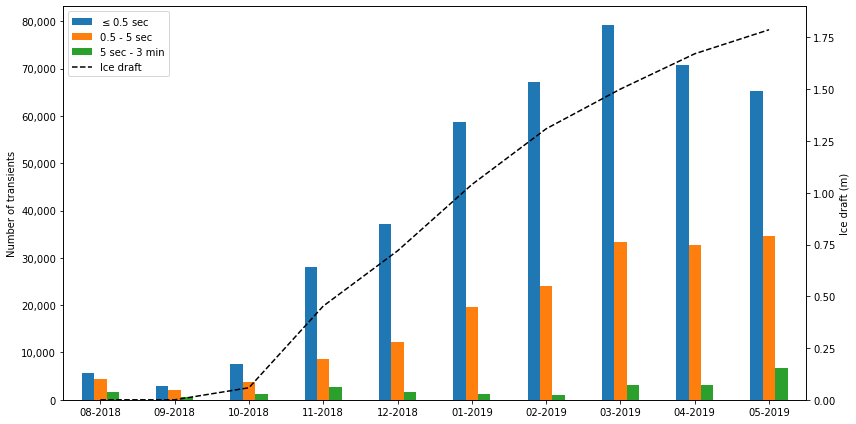

In [43]:
bar_data = pd.DataFrame({'timestamp':short_transients_df["timestamp"], 
                         'Date':short_transients_df["Date"], 
                         'short': short_transients_df["corrected_size"], 
                         'medium short': med_short_transients_df["corrected_size"], 
                         'medium': med_transients_df["corrected_size"], 
                         "ice_draft":ice_data["Ice Profiler"],
                         })

#bar_data.index = bar_data["timestamp"]
#bar_data = bar_data.set_index("timestamp")
bar_data.to_csv(config.interim_data_path + '/bar_data_for_formatting.csv')
bar_data

ax1 = bar_data.drop(['ice_draft'], axis=1).plot(x='Date', kind='bar', figsize=(12,6), legend=False)
ax1.set_ylabel("Number of transients")
ax2 = bar_data['ice_draft'].plot(secondary_y=True, ls='--', label='Ice draft (m)', color="black")
ax2.set_ylabel("Ice draft (m)")

r"$0 \less \rm{d} \leq 0.5$ sec"
r"$0.5 \less \rm{d} \leq 5$ sec"
r"$5 \less \rm{d} \leq 3 \rm{min}$"
r"$3 \rm{min} \less \rm{d} \leq 20 \rm{min}$"

fig = ax1.get_figure()
fig.legend([r"$\leq 0.5$ sec", "0.5 - 5 sec", "5 sec - 3 min", "Ice draft"], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

import matplotlib as mpl
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim(0, 1.9)

ax1.set_xlabel("")

plt.tight_layout()
plt.savefig(config.figures_path + "/transient_counts_ice_draft.png", dpi=300)

# Transient time (duration x count) instead of number of transients
##  Note currently the middle of the band is currently made up but the total should be found by adding up all the durations!

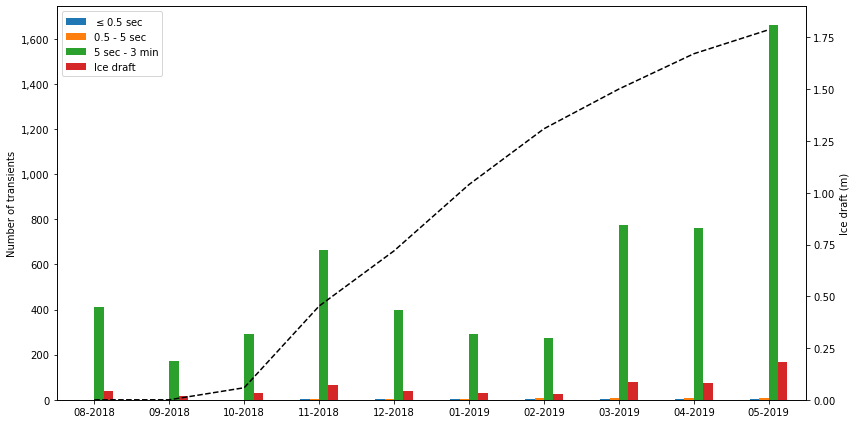

In [53]:
bar_data = pd.DataFrame({'timestamp':short_transients_df["timestamp"], 
                         'Date':short_transients_df["Date"], 
                         # DO NOT USE IN REPORT
                         # FIXME
                         'short': short_transients_df["corrected_size"]*0.25/(60**2), 
                         'medium short': med_short_transients_df["corrected_size"]*(0.5+1.5)/2/(60**2), 
                         'medium': med_transients_df["corrected_size"]*(5+30*60)/2/(60**2), 
                         'long': med_transients_df["corrected_size"]*(3*60)/2/(60**2), 
                         "ice_draft":ice_data["Ice Profiler"],
                         })

#bar_data.index = bar_data["timestamp"]
#bar_data = bar_data.set_index("timestamp")
bar_data.to_csv(config.interim_data_path + '/bar_data_for_formatting.csv')
bar_data

ax1 = bar_data.drop(['ice_draft'], axis=1).plot(x='Date', kind='bar', figsize=(12,6), legend=False)
ax1.set_ylabel("Number of transients")
ax2 = bar_data['ice_draft'].plot(secondary_y=True, ls='--', label='Ice draft (m)', color="black")
ax2.set_ylabel("Ice draft (m)")

r"$0 \less \rm{d} \leq 0.5$ sec"
r"$0.5 \less \rm{d} \leq 5$ sec"
r"$5 \less \rm{d} \leq 3 \rm{min}$"
r"$3 \rm{min} \less \rm{d} \leq 20 \rm{min}$"

fig = ax1.get_figure()
fig.legend([r"$\leq 0.5$ sec", "0.5 - 5 sec", "5 sec - 3 min", "Ice draft"], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

import matplotlib as mpl
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim(0, 1.9)

ax1.set_xlabel("")

plt.tight_layout()
plt.savefig(config.figures_path + "/transient_counts_ice_draft.png", dpi=300)

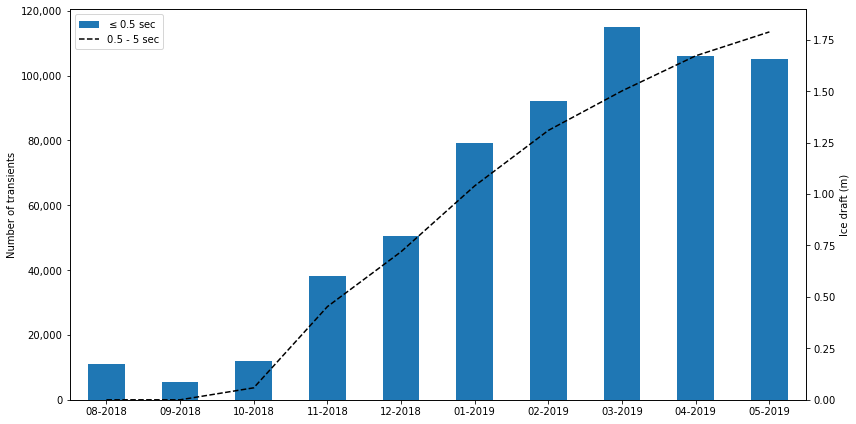

In [50]:
plot_data = pd.DataFrame({'timestamp':short_transients_df["timestamp"], 
                         'Date':short_transients_df["Date"], 
                         "all_transients" : all_transients_df["corrected_size"], 
                         "ice_draft":ice_data["Ice Profiler"],
                         })

#bar_data.index = bar_data["timestamp"]
#bar_data = bar_data.set_index("timestamp")
plot_data.to_csv(config.interim_data_path + '/bar_data_for_formatting.csv')
bar_data

ax1 = plot_data.plot(x='Date', y="all_transients", kind="bar", figsize=(12,6), legend=False)
ax1.set_ylabel("Number of transients")
ax2 = plot_data['ice_draft'].plot(secondary_y=True, ls='--', label='Ice draft (m)', color="black")
ax2.set_ylabel("Ice draft (m)")

r"$0 \less \rm{d} \leq 0.5$ sec"
r"$0.5 \less \rm{d} \leq 5$ sec"
r"$5 \less \rm{d} \leq 3 \rm{min}$"
r"$3 \rm{min} \less \rm{d} \leq 20 \rm{min}$"

fig = ax1.get_figure()
fig.legend([r"$\leq 0.5$ sec", "0.5 - 5 sec", "5 sec - 3 min", "Ice draft"], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

import matplotlib as mpl
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim(0, 1.9)

ax1.set_xlabel("")

plt.tight_layout()
plt.savefig(config.figures_path + "/transient_counts_ice_draft.png", dpi=300)

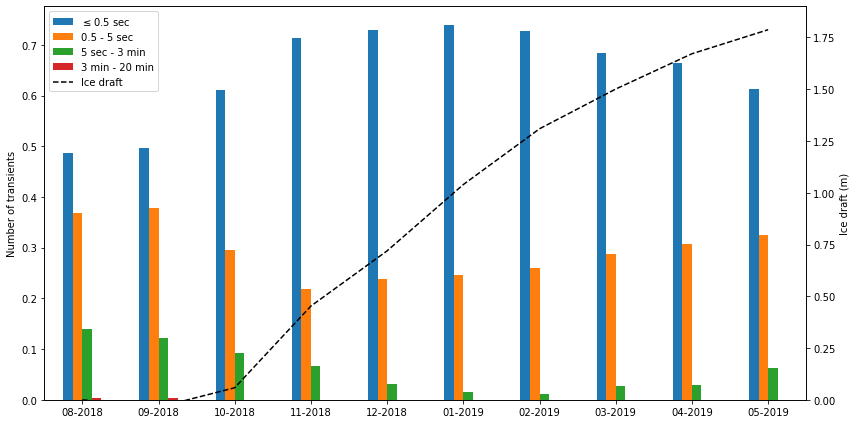

In [20]:
bar_data = pd.DataFrame({'timestamp':short_transients_df["timestamp"], 
                         'Date':short_transients_df["Date"], 
                         'short': short_transients_df["corrected_size"]/all_transients_df["corrected_size"], 
                         'medium short': med_short_transients_df["corrected_size"]/all_transients_df["corrected_size"], 
                         'medium': med_transients_df["corrected_size"]/all_transients_df["corrected_size"], 
                         'long': long_transients_df["corrected_size"]/all_transients_df["corrected_size"],
                         
                         'retained':retained_data_df["retained"],
                         "ice_draft":ice_data["Ice Profiler"],
                         })

#bar_data.index = bar_data["timestamp"]
#bar_data = bar_data.set_index("timestamp")
bar_data.to_csv(config.interim_data_path + '/bar_data_for_formatting.csv')
bar_data

ax1 = bar_data.drop(['retained', 'ice_draft'], axis=1).plot(x='Date', kind='bar', figsize=(12,6), legend=False)
ax1.set_ylabel("Number of transients")
ax2 = bar_data['ice_draft'].plot(secondary_y=True, ls='--', label='Ice draft (m)', color="black")
ax2.set_ylabel("Ice draft (m)")
ax2.set_ylim(0, 1.9)


r"$0 \less \rm{d} \leq 0.5$ sec"
r"$0.5 \less \rm{d} \leq 5$ sec"
r"$5 \less \rm{d} \leq 3 \rm{min}$"
r"$3 \rm{min} \less \rm{d} \leq 20 \rm{min}$"

fig = ax1.get_figure()
fig.legend([r"$\leq 0.5$ sec", "0.5 - 5 sec", "5 sec - 3 min", r"3 min - 20 min", "Ice draft"], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

ax1.set_xlabel("")

plt.tight_layout()
plt.savefig(config.figures_path + "/transient_counts_ice_draft.png", dpi=300)

#   Group by ice free, freeze-up, ice-cover

In [29]:
ice_free_df = whole_year_transients_df[(whole_year_transients_df["timestamp"].dt.month == 8) | (whole_year_transients_df["timestamp"].dt.month == 9)]
freeze_up_df = whole_year_transients_df[(whole_year_transients_df["timestamp"].dt.month == 10) | (whole_year_transients_df["timestamp"].dt.month == 11)]
full_ice_cover_df = whole_year_transients_df[(whole_year_transients_df["timestamp"].dt.month == 12) | (whole_year_transients_df["timestamp"].dt.year == 2019)]

In [ ]:

full_ice_cover_df

In [21]:
whole_year_transients_df

,timestamp,broadband_spl,background_spl,duration
0,2018-08-02 00:23:09.500,-48.511243,-59.933503,0.5
1,2018-08-02 00:23:10.500,-44.798160,-59.914447,0.5
2,2018-08-02 00:23:11.500,-49.693166,-59.900054,0.5
3,2018-08-02 00:23:13.000,-48.039116,-59.874419,1.0
4,2018-08-02 00:25:16.500,-44.149546,-54.485586,121.5
...,...,...,...,...
412305,2019-05-31 22:51:03.855,-43.255208,-64.609792,0.5
412306,2019-05-31 22:53:22.507,-52.194121,-64.656006,0.5
412307,2019-05-31 22:56:58.507,-52.946478,-64.694019,2.0
412308,2019-05-31 22:57:27.507,-48.559140,-63.667097,28.5
